##### Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning/Project1_NoisyMNIST/'

/content/drive/MyDrive/Colab Notebooks/CSCE636_DeepLearning


#### Load data and preprocess

In [ ]:
import pickle
import numpy as np

train_images = pickle.load(open('636_project1_train_images', 'rb'))
train_labels = pickle.load(open('636_project1_train_labels', 'rb'))

# check dimension
print(type(train_images))
print(train_images.shape)
print(type(train_labels))
print(train_labels.shape)

print(np.amax(train_images[:,:]))

# reshape and normalize the image tensors
train_images = np.array(train_images).reshape((60000, 28, 28, 1))
# train_images = np.array(train_images).reshape((60000, 28, 28))
train_images = train_images.astype("float32") / 255
train_labels = np.array(train_labels)

print(type(train_images))
print(train_images.shape)
print(type(train_labels))
print(train_labels.shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
(60000, 28, 28)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(60000,)
255
<class 'numpy.ndarray'>
(60000, 28, 28, 1)
<class 'numpy.ndarray'>
(60000,)


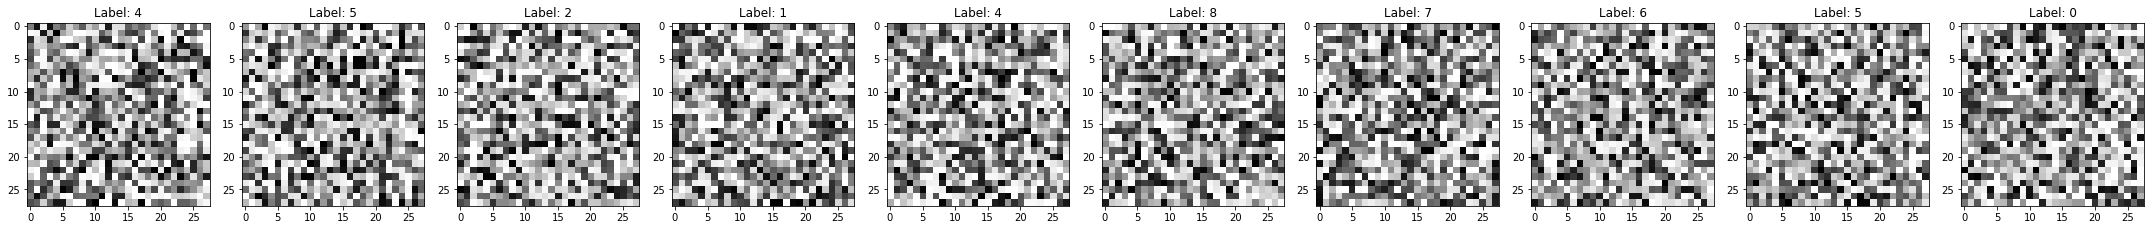

100%|██████████| 10/10 [00:00<00:00, 1038.09it/s]


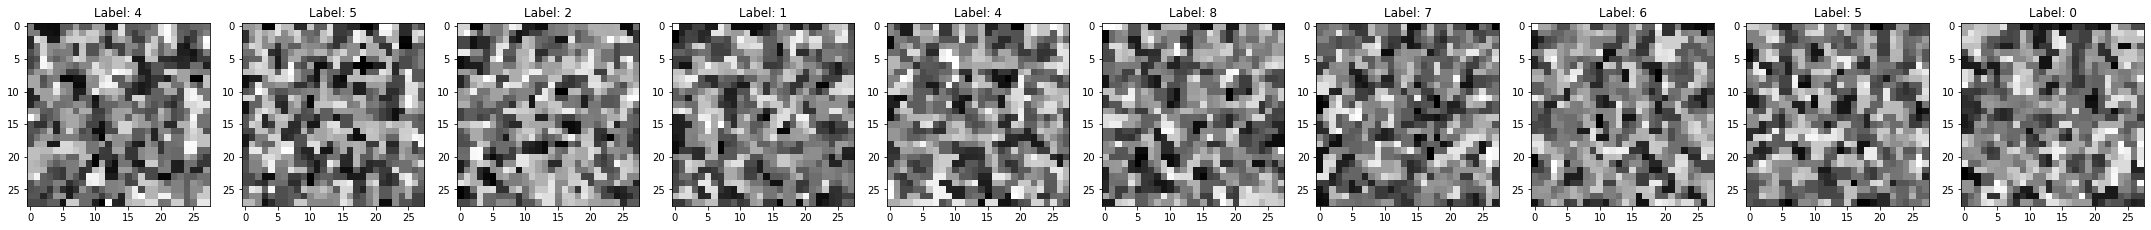

In [ ]:
# plot sample images

from scipy import ndimage
import cv2
from numpy import random
import matplotlib.pyplot as plt
from tqdm import tqdm

def filter_image(sample):
  # result = sample
  
  # sample = sample.reshape(28, 28)

  result = ndimage.median_filter(sample, size=2) # hurt the original pixels
  # # result = cv2.medianBlur(sample, 3)
  # # result = cv2.GaussianBlur(sample, (3,3), 0)
  # result = sample


  # dim1, dim2 = sample.shape[:2]
  # result = np.zeros((dim1,dim2))
  # for i in range(dim1):
  #   for j in range(dim2):
  #     if sample[i,j] > 0.1:
  #       result[i,j] = sample[i,j]

  return result


num_sample = 10

idx = [random.randint(0, train_images.shape[0]) for i in range(num_sample)]

# plot original noisy images
fig, axes = plt.subplots(1, 10)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = train_images[idx[i], :].reshape(28, 28)
  im = axes[i].imshow(sample_img, cmap='Greys') #vmax=0.5
  axes[i].set_title('Label: {}'.format(train_labels[idx[i]]))

# fig.colorbar(im, ax=axes[num_sample-1])
plt.tight_layout()
plt.show()

# plot images after median filter
fig, axes = plt.subplots(1, 10)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in tqdm(range(num_sample)):
  sample_img = train_images[idx[i], :]
  sample_img = filter_image(sample_img)
  axes[i].imshow(sample_img.reshape(28,28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(train_labels[idx[i]]))

plt.tight_layout()
plt.show()

In [ ]:
# preprocess all the train_images

from tqdm import tqdm

train_images_p = np.zeros(train_images.shape)
for i in tqdm(range(train_images.shape[0])):
  img = train_images[i, :, :]
  img_p = filter_image(img)
  train_images_p[i,:] = img_p

print()
print(train_images_p.shape)
print(np.amin(train_images_p))

# replace train_images
train_images = train_images_p

100%|██████████| 60000/60000 [00:03<00:00, 15689.28it/s]



(60000, 28, 28)
0.0


In [ ]:
# split into train and val dataset

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(54000, 28, 28, 1)
(54000,)
(6000, 28, 28, 1)
(6000,)


Add original MNIST train and test data to the training dataset to help the model learn better

In [ ]:
from tensorflow.keras.datasets import mnist

(train_images_clean, train_labels_clean), (test_images_clean, test_labels_clean) = mnist.load_data()
train_images_clean = train_images_clean.reshape((60000, 28, 28, 1))
train_images_clean = train_images_clean.astype("float32") / 255
test_images_clean = test_images_clean.reshape((10000, 28, 28, 1))
test_images_clean = test_images_clean.astype("float32") / 255

In [ ]:
# collect by labels and average the images under the same label

import matplotlib.pyplot as plt
from numpy import random

def collect_by_label(image, labels, idx):
  is_idx = (labels==idx)
  print(type(is_idx))

  avg = np.zeros(image[0].shape)
  for i, match in enumerate(is_idx):
    if match:
      avg += image[i,:]
  match_ct = is_idx.sum()

  avg /= match_ct

  return avg

avg_image = dict()
for i in range(10):
  avg = collect_by_label(train_images_clean, train_labels_clean, i)
  avg_image[i] = avg

# plot clean images 
fig, axes = plt.subplots(1, 10)
fig.set_figheight(3)
fig.set_figwidth(3*10)
for i in range(10):
  sample_img = avg_image[i]
  axes[i].imshow(sample_img.reshape(28, 28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(i))

plt.tight_layout()
plt.show()

In [ ]:
# concatenate the noisy train data with the original train and test data
X_train_agg = np.vstack([X_train, train_images_clean, test_images_clean])
y_train_agg = np.concatenate([y_train, train_labels_clean, test_labels_clean])

print(X_train_agg.shape)
print(y_train_agg.shape)

In [ ]:
# check if two labels (noisy MNIST vs. clean MNIST) are equal, turns out not
print(train_labels.shape)
print(train_labels_clean.shape)

print(train_labels[:20])
print(train_labels_clean[-20:])

print(np.array_equal(train_labels, train_labels_clean))

for i in range(10):
  print('label {} has {} noisy images, {} clean images'.format(i, (train_labels==i).sum(), (train_labels_clean==i).sum()))

In [ ]:
# add noise to clean images to build my own noisy train images
denoiser_y_train = train_images_clean
denoiser_y_test = test_images_clean

import numpy as np

# snr = 0.8 #signal/noise where max signal value is 1 (based on normalization described above)

# # add noise to training data
# noise = np.random.uniform(-(1/snr),+(1/snr), denoiser_y_train.shape)
# noisy_image = denoiser_y_train + noise
# noisy_image[noisy_image>1]=1 # make 1 the maximum value
# noisy_image[noisy_image<0]=0 # make 0 th eminimum value
# denoiser_x_train = noisy_image

# # add noise to test data
# noise = np.random.uniform(-(1/snr),+(1/snr),denoiser_y_test.shape)
# noisy_image = denoiser_y_test + noise
# noisy_image[noisy_image>1]=1
# noisy_image[noisy_image<0]=0
# denoiser_x_test = noisy_image

#--------------------------------
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 1.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

denoiser_x_train = noise(train_images_clean)
denoiser_x_test = noise(test_images_clean)

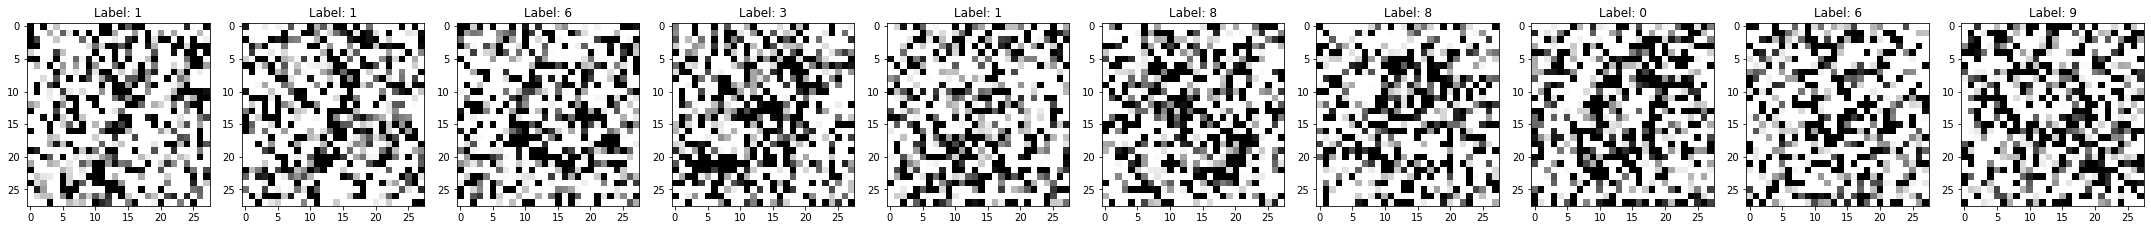

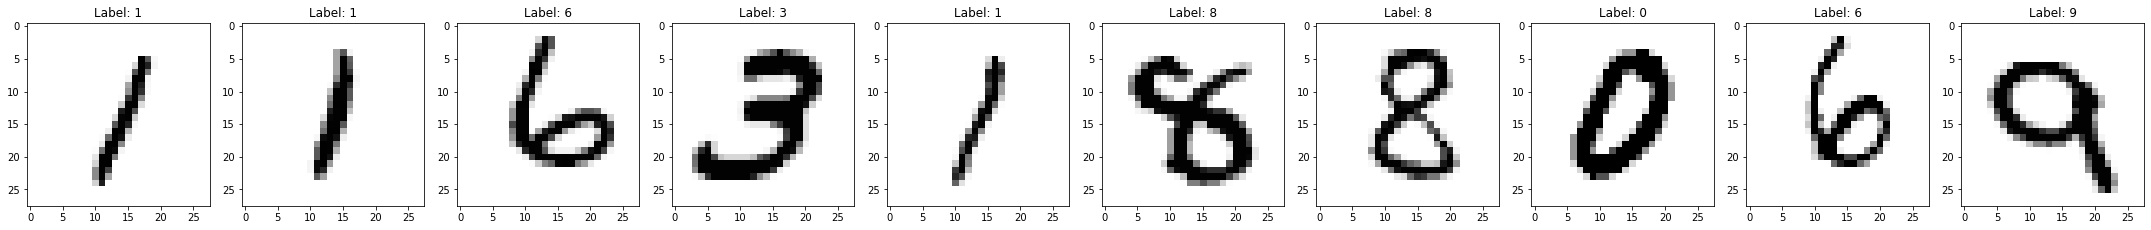

In [ ]:
# Plot a noisy image vs. groundtruth
import matplotlib.pyplot as plt
from numpy import random

num_sample = 10
idx = [np.random.randint(0, denoiser_x_train.shape[0]) for i in range(num_sample)]

# plot noisy images 
fig, axes = plt.subplots(1, num_sample)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = denoiser_x_train[idx[i], :]
  axes[i].imshow(sample_img.reshape(28,28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(train_labels_clean[idx[i]]))

plt.tight_layout()
plt.show()

# plot clean images 
fig, axes = plt.subplots(1, num_sample)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = denoiser_y_train[idx[i], :]
  axes[i].imshow(sample_img.reshape(28, 28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(train_labels_clean[idx[i]]))

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# train the auto-encoder
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)

#### Set the label of noist training images to the averaged clean MNIST images

In [ ]:
from sklearn.model_selection import train_test_split

def get_labels(labels, avg_img):

  result = np.zeros((len(labels), avg_img[0].shape[0], avg_img[0].shape[1], 1))

  for i, lab in enumerate(labels):
    result[i,:] = avg_img[lab]

  return result

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, shuffle=True)

denoiser_x_train_1 = X_train
denoiser_x_test_1 = X_val

denoiser_y_train_1 = get_labels(y_train, avg_image) 
denoiser_y_test_1 =  get_labels(y_val, avg_image)


In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(denoiser_x_train, denoiser_y_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(denoiser_x_test, denoiser_y_test))

Epoch 1/50
469/469 [==============================] - 7s 8ms/step - loss: 0.2411 - val_loss: 0.2041
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2019 - val_loss: 0.1969
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1966 - val_loss: 0.1934
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1931 - val_loss: 0.1906
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1908 - val_loss: 0.1883
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1891 - val_loss: 0.1867
Epoch 7/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1876 - val_loss: 0.1865
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.1865 - val_loss: 0.1849
Epoch 9/50
469/469 [==============================] - 4s 7ms/step - loss: 0.1856 - val_loss: 0.1837
Epoch 10/50
469/469 [==============================] - 3s 7ms/step - loss: 0.1848 - val_loss: 0.1836

In [ ]:
x_test_pred = autoencoder.predict(denoiser_x_test)

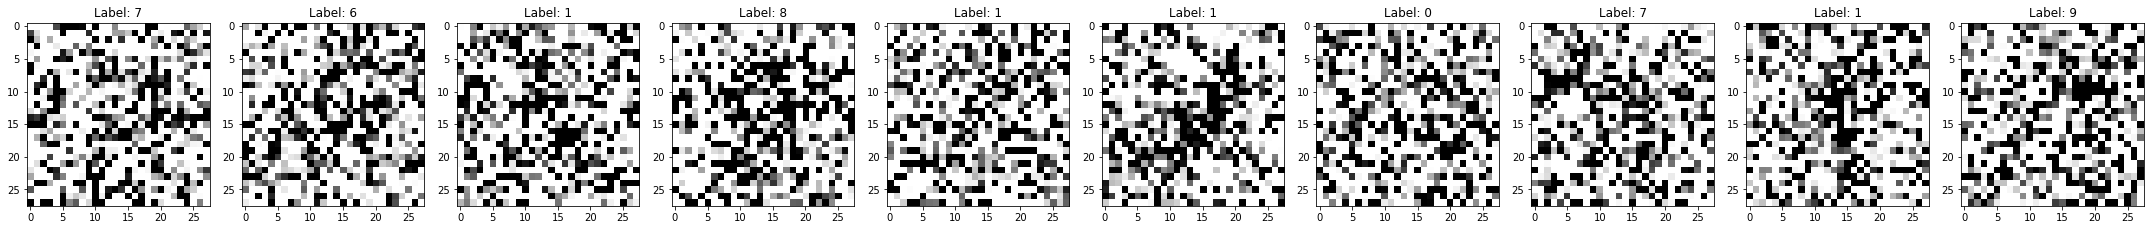

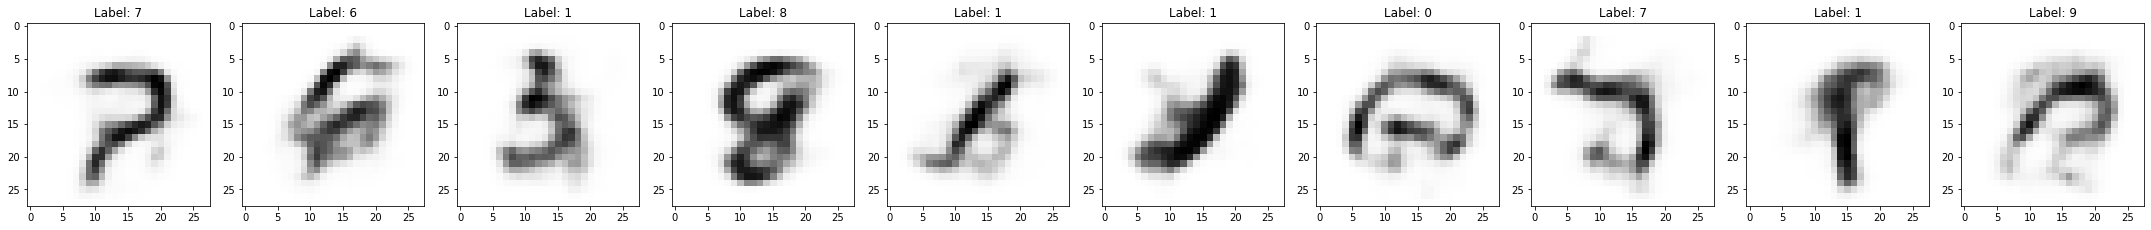

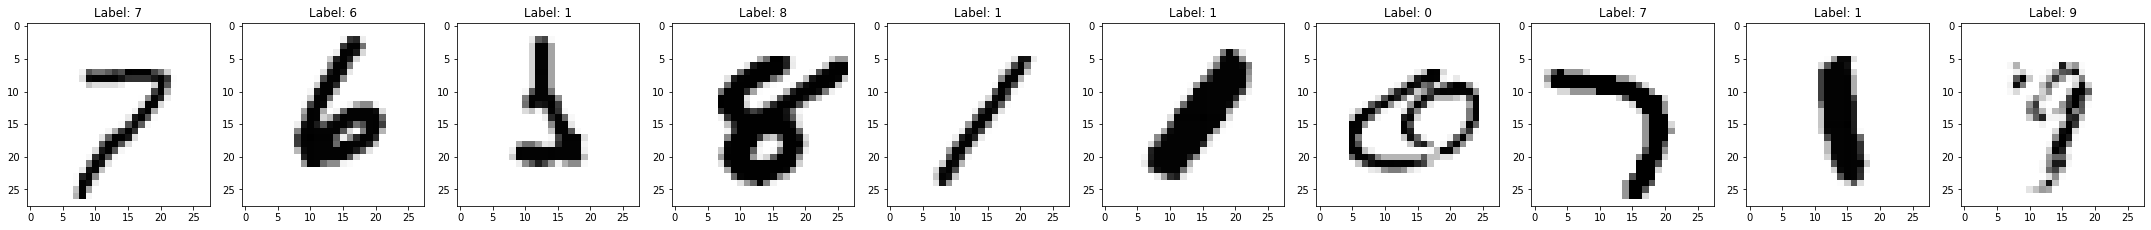

In [ ]:
# Plot a noisy image vs. groundtruth
import matplotlib.pyplot as plt
from numpy import random

num_sample = 10
idx = [np.random.randint(0, denoiser_x_test.shape[0]) for i in range(num_sample)]

# plot noisy images 
fig, axes = plt.subplots(1, num_sample)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = denoiser_x_test[idx[i], :]
  axes[i].imshow(sample_img.reshape(28,28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(test_labels_clean[idx[i]]))

plt.tight_layout()
plt.show()

# plot denoised images 
fig, axes = plt.subplots(1, num_sample)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = x_test_pred[idx[i], :]
  axes[i].imshow(sample_img.reshape(28, 28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(test_labels_clean[idx[i]]))

plt.tight_layout()
plt.show()

# plot clean images 
fig, axes = plt.subplots(1, num_sample)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = denoiser_y_test[idx[i], :]
  axes[i].imshow(sample_img.reshape(28, 28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(test_labels_clean[idx[i]]))

plt.tight_layout()
plt.show()

In [ ]:
denoised_train_images = autoencoder.predict(train_images)

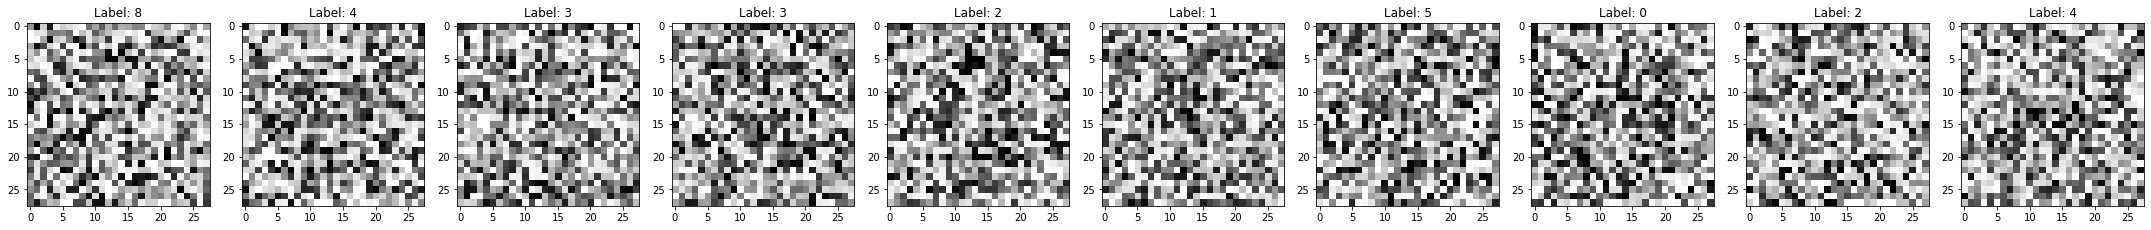

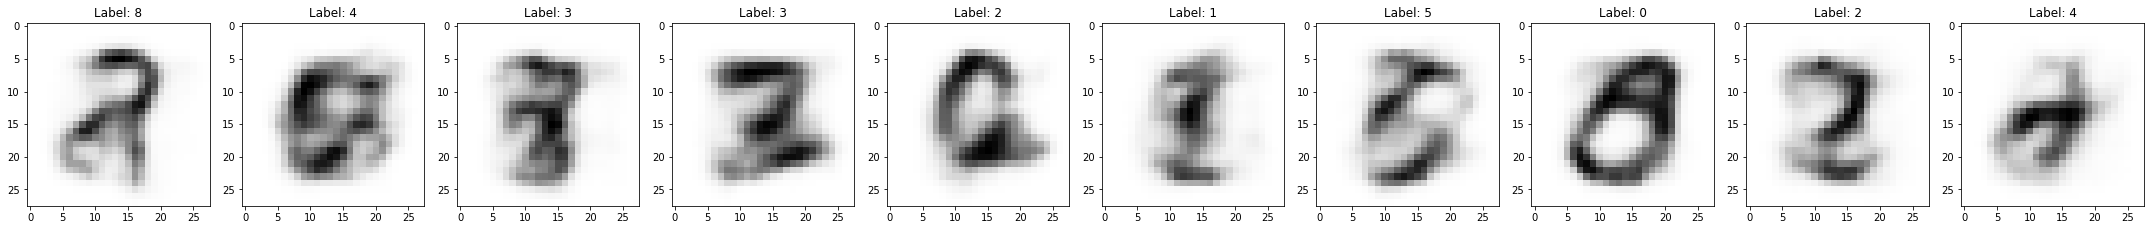

In [ ]:
# test the denoiser performance on given dataset

import matplotlib.pyplot as plt
from numpy import random

num_sample = 10
idx = [np.random.randint(0, train_images.shape[0]) for i in range(num_sample)]

# plot noisy images 
fig, axes = plt.subplots(1, num_sample)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = train_images[idx[i], :]
  axes[i].imshow(sample_img.reshape(28,28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(train_labels[idx[i]]))

plt.tight_layout()
plt.show()

# plot denoised images 
fig, axes = plt.subplots(1, num_sample)
fig.set_figheight(3)
fig.set_figwidth(3*num_sample)
for i in range(num_sample):
  sample_img = denoised_train_images[idx[i], :]
  axes[i].imshow(sample_img.reshape(28, 28), cmap='Greys')
  axes[i].set_title('Label: {}'.format(train_labels[idx[i]]))

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(denoised_train_images, train_labels, test_size=0.1, shuffle=True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(54000, 28, 28, 1)
(54000,)
(6000, 28, 28, 1)
(6000,)


#### Define CNN model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        # layers.Rescaling(scale=1./255),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
     # maybe add some noises here as well
        # layers.GaussianNoise(1.0),
    ]
)

inputs = keras.Input(shape=(28, 28, 1))

# x = autoencoder.predict(inputs)

# data augmentation
x = data_augmentation(inputs)

# autoencoder.predict(train_images)

# # use encoder and decoder structure for denoise

# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
# # At this point the representation is (7, 7, 32)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = layers.UpSampling2D((2, 2))(x)
# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = layers.UpSampling2D((2, 2))(x)
# decoded = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

# classifier part 

x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
x = layers.Flatten()(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
import tensorflow as tf

# use learning rate decay 

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=2000,
#     decay_rate=0.9)

# opt = keras.optimizers.SGD(learning_rate=lr_schedule)

# opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
              optimizer='adam',
              # optimizer=opt,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# callbacks = [
#     keras.callbacks.ModelCheckpoint(
#         filepath="model.best",
#         save_best_only=True,
#         monitor="val_loss")
# ]

history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val), shuffle=True)

# test aggregated train and val data
# history = model.fit(X_train_agg, y_train_agg, epochs=50, batch_size=256, validation_data=(X_val, y_val), shuffle=True) #,  callbacks=callbacks

Epoch 1/50
211/211 [==============================] - 9s 37ms/step - loss: 2.1087 - accuracy: 0.2347 - val_loss: 1.8119 - val_accuracy: 0.3802
Epoch 2/50
211/211 [==============================] - 7s 34ms/step - loss: 1.8975 - accuracy: 0.3340 - val_loss: 1.7193 - val_accuracy: 0.4075
Epoch 3/50
211/211 [==============================] - 7s 35ms/step - loss: 1.8327 - accuracy: 0.3594 - val_loss: 1.6702 - val_accuracy: 0.4322
Epoch 4/50
211/211 [==============================] - 7s 34ms/step - loss: 1.7906 - accuracy: 0.3759 - val_loss: 1.6357 - val_accuracy: 0.4443
Epoch 5/50
211/211 [==============================] - 7s 34ms/step - loss: 1.7654 - accuracy: 0.3876 - val_loss: 1.6119 - val_accuracy: 0.4512
Epoch 6/50
211/211 [==============================] - 7s 35ms/step - loss: 1.7536 - accuracy: 0.3925 - val_loss: 1.5986 - val_accuracy: 0.4558
Epoch 7/50
211/211 [==============================] - 7s 34ms/step - loss: 1.7436 - accuracy: 0.3980 - val_loss: 1.5964 - val_accuracy: 0.4585

In [ ]:
# train on ANN model

X_train = X_train.reshape(54000, 28*28)
X_val = X_val.reshape(6000, 28*28)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

model = keras.Sequential([
    layers.Dense(256, activation="relu"),# kernel_regularizer=regularizers.l2(0.0001)), # use L2 regularization
    layers.BatchNormalization(),
    # layers.LayerNormalization(),
    # layers.Dropout(0.8), # add dropout layer

    layers.Dense(128, activation="relu"), #kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    # layers.Dropout(0.8), # add dropout layer
    
    layers.Dense(10, activation="softmax"), #kernel_regularizer=regularizers.l2(0.0001))
])

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/20
106/106 [==============================] - 2s 7ms/step - loss: 1.1519 - accuracy: 0.6103 - val_loss: 1.8890 - val_accuracy: 0.3733
Epoch 2/20
106/106 [==============================] - 1s 6ms/step - loss: 1.0592 - accuracy: 0.6382 - val_loss: 1.4882 - val_accuracy: 0.5100
Epoch 3/20
106/106 [==============================] - 1s 6ms/step - loss: 1.0364 - accuracy: 0.6447 - val_loss: 1.2830 - val_accuracy: 0.5513
Epoch 4/20
106/106 [==============================] - 1s 6ms/step - loss: 1.0184 - accuracy: 0.6507 - val_loss: 1.1431 - val_accuracy: 0.6042
Epoch 5/20
106/106 [==============================] - 1s 6ms/step - loss: 1.0067 - accuracy: 0.6531 - val_loss: 1.1752 - val_accuracy: 0.6018
Epoch 6/20
106/106 [==============================] - 1s 6ms/step - loss: 0.9977 - accuracy: 0.6569 - val_loss: 1.1057 - val_accuracy: 0.6212
Epoch 7/20
106/106 [==============================] - 1s 6ms/step - loss: 0.9898 - accuracy: 0.6604 - val_loss: 1.1452 - val_accuracy: 0.6185
Epoch 